# generating dataset of triples

The purpose of this notebook is to generate triplets to create a dataset for
training. It should contain a fairly large number of examples. Let's create 3
dataset with 100k, 1m, and 10m rows. We'll train the unsupervised model against
all three of these.

We're going to be clever about how we sample from the motif dataset. We utilize
the sampling method referenced in tile2vec. Neighbors are drawn from both within
the same audio sample and within a species. The distant neighbor is drawn from
from the entire dataset, using both a random motif, and an entirely random
sample from across the dataset.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [9]:
from pyspark.sql import SparkSession, functions as F
import os
import sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
spark = SparkSession.builder.getOrCreate()
spark

df = (
    spark.read.parquet("../data/intermediate/2022-02-26-motif-consolidated.parquet")
    .repartition(8)
    .cache()
)
df.show()

+--------------------+----------------+---------------------+-------+-------+-----------+-------------+----------------+----------------+
|         source_name|cens_sample_rate|matrix_profile_window|motif_0|motif_1|sample_rate|duration_cens|duration_samples|duration_seconds|
+--------------------+----------------+---------------------+-------+-------+-----------+-------------+----------------+----------------+
|train_audio/comsa...|              10|                   50|  331.0|  386.0|      22050|          642|         1396030|           63.31|
|train_audio/mitpa...|              10|                   50|  109.0|  135.0|      22050|          227|          493056|           22.36|
|train_audio/gadwa...|              10|                   50|   79.0|   38.0|      22050|          596|         1294848|           58.72|
|train_audio/bkbpl...|              10|                   50|    0.0|    0.0|      22050|           64|          138240|            6.27|
|train_audio/gnwte...|            

In [16]:
df.selectExpr("count(*)", "sum(if(duration_seconds < 5, 1, 0))").show()

+--------+---------------------------------------+
|count(1)|sum((IF((duration_seconds < 5), 1, 0)))|
+--------+---------------------------------------+
|   14852|                                    996|
+--------+---------------------------------------+



In [106]:
taxa = spark.read.csv("../data/raw/birdclef-2022/eBird_Taxonomy_v2021.csv", header=True)
taxa.show()

+-----------+--------+------------+--------------------+--------------------+----------------+--------------------+-------------+---------+
|TAXON_ORDER|CATEGORY|SPECIES_CODE|    PRIMARY_COM_NAME|            SCI_NAME|          ORDER1|              FAMILY|SPECIES_GROUP|REPORT_AS|
+-----------+--------+------------+--------------------+--------------------+----------------+--------------------+-------------+---------+
|          1| species|     ostric2|      Common Ostrich|    Struthio camelus|Struthioniformes|Struthionidae (Os...|    Ostriches|     null|
|          6| species|     ostric3|      Somali Ostrich|Struthio molybdop...|Struthioniformes|Struthionidae (Os...|         null|     null|
|          7|   slash|      y00934|Common/Somali Ost...|Struthio camelus/...|Struthioniformes|Struthionidae (Os...|         null|     null|
|          8| species|     grerhe1|        Greater Rhea|      Rhea americana|      Rheiformes|     Rheidae (Rheas)|        Rheas|     null|
|         14| specie

In [112]:
taxa.groupBy("FAMILY").count().show()

+--------------------+-----+
|              FAMILY|count|
+--------------------+-----+
|Formicariidae (An...|   17|
|Ramphastidae (Tou...|   74|
|Oxyruncidae (Shar...|   18|
|Acanthizidae (Tho...|   78|
|Phalacrocoracidae...|   60|
|Acanthisittidae (...|    4|
|Stenostiridae (Fa...|   11|
|Icteridae (Troupi...|  177|
|Neosittidae (Sitt...|    8|
|Nicatoridae (Nica...|    4|
|Polioptilidae (Gn...|   37|
|    Todidae (Todies)|    6|
|Oreoicidae (Austr...|    3|
|Aegithinidae (Ioras)|    5|
|    Gruidae (Cranes)|   25|
|Pomatostomidae (P...|    6|
|Thinocoridae (See...|    4|
|Corvidae (Crows, ...|  205|
|Anseranatidae (Ma...|    1|
|Pachycephalidae (...|   85|
+--------------------+-----+
only showing top 20 rows



In [113]:
df = df.withColumn("species", F.split("source_name", "/")[1])
df.groupBy("species").count().count()

152

In [118]:
df.join(
    taxa.selectExpr("SPECIES_CODE as species", "FAMILY as family"),
    on="species",
    how="left",
).groupBy("family").count().show()

+--------------------+-----+
|              family|count|
+--------------------+-----+
|Icteridae (Troupi...|  343|
|Accipitridae (Haw...|   34|
|Fregatidae (Friga...|   17|
|Charadriidae (Plo...|  401|
|Procellariidae (S...|   85|
|Sulidae (Boobies ...|   80|
|Scolopacidae (San...| 1971|
|Hydrobatidae (Nor...|   28|
|Scotocercidae (Bu...|   78|
|Columbidae (Pigeo...|  494|
|Fringillidae (Fin...|  597|
|Phaethontidae (Tr...|   55|
|Odontophoridae (N...|  242|
|Alcedinidae (King...|  100|
|Phasianidae (Phea...|  659|
|Turdidae (Thrushe...|  125|
|Pandionidae (Osprey)|  228|
|Threskiornithidae...|   45|
|Laridae (Gulls, T...|  838|
|Stercorariidae (S...|  119|
+--------------------+-----+
only showing top 20 rows



In [103]:
freq_df = df.groupby("species").count().orderBy("count")
freq_df.show(truncate=False, n=10)

+-------+-----+
|species|count|
+-------+-----+
|maupar |1    |
|crehon |2    |
|akikik |2    |
|layalb |3    |
|coopet |3    |
|shtsan |3    |
|bkwpet |3    |
|hawhaw |3    |
|mauala |3    |
|hawpet1|3    |
+-------+-----+
only showing top 10 rows



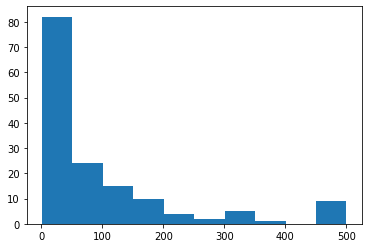

In [35]:
import matplotlib.pyplot as plt

pdf = freq_df.toPandas()
plt.hist(pdf["count"])
plt.show()

In [37]:
df.select("species").distinct().count()

152

In [59]:
total = df.count()
freq = {r.species: r["count"] / total for r in freq_df.collect()}
freq

{'brant': 0.009089684890923782,
 'bknsti': 0.012052248855373014,
 'compea': 0.0037032049555615404,
 'pagplo': 0.0035685429571774845,
 'hudgod': 0.0005386479935362241,
 'peflov': 0.0025585779692970643,
 'mauala': 0.00020199299757608404,
 'elepai': 0.0009426339886883921,
 'rempar': 0.0026259089684890925,
 'bubsan': 0.00033665499596014,
 'zebdov': 0.0059924589280904925,
 'brnnod': 0.00134661998384056,
 'cintea': 0.0010772959870724481,
 'pibgre': 0.010907621869108538,
 'hoomer': 0.00134661998384056,
 'commyn': 0.014004847831941825,
 'perfal': 0.01252356584971721,
 'comsan': 0.033665499596014004,
 'hawcre': 0.00134661998384056,
 'wesmea': 0.02309453272286561,
 'grbher3': 0.006800430918394829,
 'calqua': 0.009022353891731753,
 'osprey': 0.015351467815782387,
 'norsho': 0.007137085914354969,
 'moudov': 0.009561001885267978,
 'kalphe': 0.0011446269862644763,
 'hawgoo': 0.0006059789927282521,
 'redava': 0.0024239159709130084,
 'cangoo': 0.021411257743064908,
 'norpin': 0.007541071909507137,
 'h

In [64]:
df.count()

14852

In [73]:
sampled = df.sampleBy("species", fractions=freq)
sampled.groupby("species").count().show(n=10)
sampled.count()

+-------+-----+
|species|count|
+-------+-----+
|  brant|    2|
| commyn|    3|
| comsan|   14|
| osprey|    5|
| moudov|    2|
| cangoo|   10|
| rorpar|    5|
| bcnher|   15|
| eurwig|    5|
| houspa|   19|
+-------+-----+
only showing top 10 rows



279

In [78]:
max(freq.values())

0.033665499596014004

In [87]:
mu = int(1 / max(freq.values()))
print(mu)
max_freq = {k: v * mu for k, v in freq.items()}

29


In [101]:
df.sampleBy("species", fractions=freq).count()

289

In [95]:
import functools

n_samples = int(1e6)

# we generate two sets of dataset, and then union them at the end first generate
# the same of completely random samples. This will comprise of half our distant
# data. The other half will comprise of random samples from motifs. We will
# always choose to use stratified sampling in order to represent all species
# equally.

est_size = df.sampleBy("species", fractions=max_freq).count()
a# then we union this many together, in order to get roughly our dataset size.
# Note that we try to increase the sample size for the fraction of items to
# samples as close to 1 as we can, so we can reduce the number of times that we
# sample things
print("sample size", est_size)

stratified_motif_df = (
    functools.reduce(
        lambda x, y: x.union(y),
        [
            df.sampleBy("species").select(
                "source_name", "species", "motif_0", "motif_1"
            )
            for i in range(n_samples // est_size // 2)
        ],
    )
    .repartition(8)
    .cache()
)

stratified_motif_df.show()

sample size 7613
+--------------------+-------+-------+-------+
|         source_name|species|motif_0|motif_1|
+--------------------+-------+-------+-------+
|train_audio/dunli...| dunlin|  138.0|  112.0|
|train_audio/brnow...| brnowl|  116.0|   59.0|
|train_audio/malla...|mallar3| 1855.0| 1707.0|
|train_audio/malla...|mallar3|  935.0|  152.0|
|train_audio/pibgr...| pibgre|    0.0|   81.0|
|train_audio/norpi...| norpin|    0.0|   25.0|
|train_audio/eurwi...| eurwig|  284.0|  310.0|
|train_audio/skyla...| skylar|   53.0|    0.0|
|train_audio/norsh...| norsho|   null|   null|
|train_audio/cacgo...|cacgoo1|  133.0|  159.0|
|train_audio/ospre...| osprey| 3129.0| 3028.0|
|train_audio/normo...| normoc| 2054.0| 1781.0|
|train_audio/brnow...| brnowl|   77.0|  236.0|
|train_audio/norca...| norcar|  211.0|  185.0|
|train_audio/malla...|mallar3|    0.0|   25.0|
|train_audio/malla...|mallar3|   40.0|   14.0|
|train_audio/normo...| normoc| 1159.0| 1283.0|
|train_audio/gnwte...| gnwtea|    0.0|   25

In [96]:
stratified_motif_df.count()

497752

In [99]:
stratified_motif_df.groupby("species").count().orderBy(F.desc("count")).show()

+-------+-----+
|species|count|
+-------+-----+
| houspa|31767|
| skylar|31764|
|mallar3|31743|
| brnowl|31722|
| comsan|31716|
| norcar|31691|
| dunlin|28707|
| gnwtea|27280|
| bcnher|27113|
| normoc|18954|
| wesmea|14995|
| eurwig|14625|
| houfin|13144|
| cangoo|12756|
| rorpar|12250|
| gwfgoo| 9426|
| bkbplo| 9356|
| rinphe| 7918|
| gadwal| 7284|
| osprey| 6673|
+-------+-----+
only showing top 20 rows



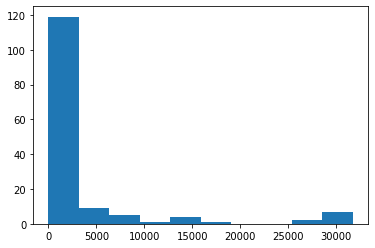

In [97]:
pdf = stratified_motif_df.groupby("species").count().toPandas()
plt.hist(pdf["count"])
plt.show()